In [1]:
!pip install wandb

In [2]:
import torch
from torch import nn
import pandas as pd
import numpy as np
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import wandb

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [5]:
wandb.init(project="Credit Card Fraud", entity="kreeeeesha")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [49]:
data = pd.read_csv('/content/creditcard.csv')

In [7]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0.0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0.0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0.0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0.0


In [8]:
data_transformed = data.copy()

In [9]:
scaler = StandardScaler()
data_transformed.iloc[:, :-1] = scaler.fit_transform(data_transformed.iloc[:, :-1])


In [10]:
normal_data = data_transformed[data_transformed['Class'] == 0].drop(['Time','Class'], axis=1)  # Drop label column for training
anomalous_data = data_transformed[data_transformed['Class'] == 1].drop(['Time','Class'], axis=1)  # Drop label column for testing

# Train-test split for normal data (only for training)
X_train, X_test = train_test_split(normal_data, test_size=0.1, random_state=42)

# For testing, keep both normal and anomalous data
X_test = pd.concat([X_test, anomalous_data])

# You can also create labels for the test set (0 = normal, 1 = anomaly)
y_test = pd.concat([pd.Series([0] * len(X_test), name='Class'),
                    pd.Series([1] * len(anomalous_data), name='Class')])

In [11]:
X_test.shape

(24965, 29)

In [12]:
X_train.shape

(220635, 29)

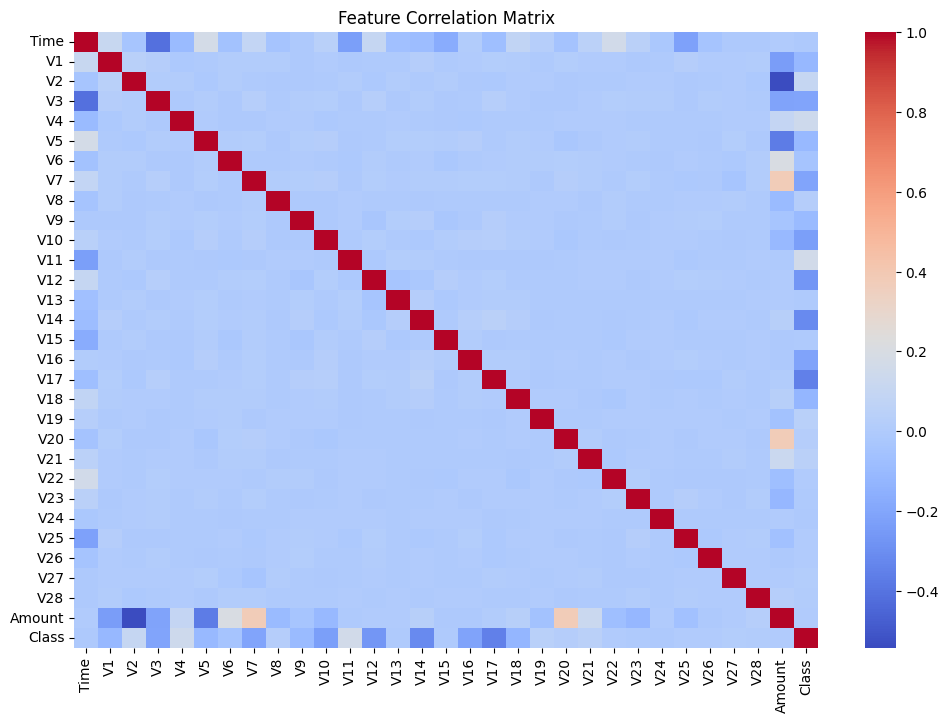

In [13]:
# Calculate the correlation matrix
corr_matrix = data.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False)
plt.title('Feature Correlation Matrix')
plt.show()


In [14]:
X_train_tensor = torch.tensor(X_train.values, dtype = torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype = torch.float32)

In [15]:
class Autoencoder(nn.Module):
    def __init__(self, input_size, code_size):
        super().__init__()
        self.enc_container = nn.Sequential(
                                nn.Linear(input_size, 20),
                                nn.LeakyReLU(),
                                nn.Linear(20, 32),
                                nn.LeakyReLU(),
                                nn.Linear(32, 16),
                                nn.LeakyReLU(),
                                nn.Linear(16, code_size))
        self.dec_container = nn.Sequential(
                                nn.Linear(code_size, 16),
                                nn.LeakyReLU(),
                                nn.Linear(16, 32),
                                nn.LeakyReLU(),
                                nn.Linear(32, 20),
                                nn.LeakyReLU(),
                                nn.Linear(20, input_size))
    def forward(self,x):
        x = self.enc_container(x)
        x = self.dec_container(x)
        return x

In [16]:
X_train.shape

(220635, 29)

In [17]:
input_size = X_train.shape[1]

In [18]:
code_size = 8
learning_rate = 5e-5
batch_size = 32
num_epochs = 100

In [19]:
train_dataset = TensorDataset(X_train_tensor, X_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [20]:
# data

This is used to make our dataset suitable for training. The TensorDataset is used to make the (input,output) combinations and the DataLoader is used to send the data in batches for efficient and fast training.

In [21]:
model = Autoencoder(input_size, code_size)

In [22]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [23]:
wandb.log({"learning_rate": learning_rate})

In [24]:
losses = []
for epoch in range(num_epochs):
    for train_data in train_loader:
        inputs, _ = train_data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
    losses.append(loss)
    print(f'Epoch {epoch+1}: {loss}')
    wandb.log({"train_loss": loss})

Epoch 1: 0.5617188215255737
Epoch 2: 0.6617263555526733
Epoch 3: 0.8994206190109253
Epoch 4: 1.1483266353607178
Epoch 5: 0.4855566918849945
Epoch 6: 0.669207751750946
Epoch 7: 0.41227877140045166
Epoch 8: 0.7022887468338013
Epoch 9: 0.5580499172210693
Epoch 10: 0.5155953168869019
Epoch 11: 0.48296046257019043
Epoch 12: 0.6175405979156494
Epoch 13: 0.9208087921142578
Epoch 14: 0.5366806387901306
Epoch 15: 0.4701150953769684
Epoch 16: 0.4842109680175781
Epoch 17: 0.5553091764450073
Epoch 18: 0.4932205080986023
Epoch 19: 0.4195290803909302
Epoch 20: 0.3831706941127777
Epoch 21: 0.46893221139907837
Epoch 22: 0.3314213752746582
Epoch 23: 6.880507469177246
Epoch 24: 0.4404928386211395
Epoch 25: 0.3987518846988678
Epoch 26: 0.5158212184906006
Epoch 27: 0.3919388949871063
Epoch 28: 0.43966764211654663
Epoch 29: 0.524509072303772
Epoch 30: 0.33344566822052
Epoch 31: 0.4618372917175293
Epoch 32: 2.897653579711914
Epoch 33: 0.32927337288856506
Epoch 34: 0.3737322986125946
Epoch 35: 0.385886818170

In [48]:
reconstruction_errors = []
for train_data in train_loader:  # Loop through batches
    inputs, _ = train_data  # Get inputs (and ignore labels if they exist)
    outputs = model(inputs)  # Get model output (reconstruction)
    batch_error = criterion(outputs, inputs)  # MSE directly calculates the error
    reconstruction_errors.append(batch_error.item())  # Append scalar error to the list


In [32]:
losses = [loss.detach().numpy() for loss in losses]

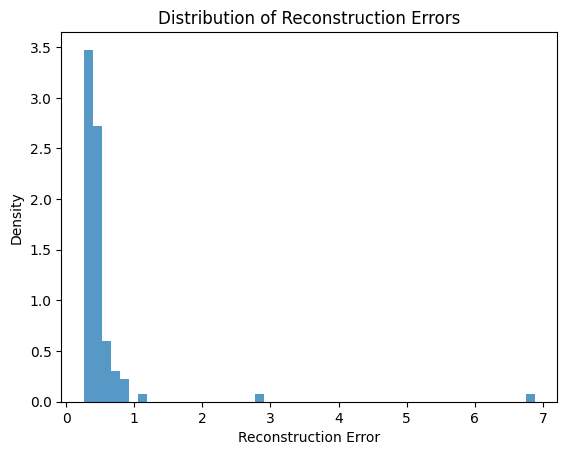

In [33]:
plt.hist(losses, bins=50, density=True, alpha=0.75)
plt.title('Distribution of Reconstruction Errors')
plt.xlabel('Reconstruction Error')
plt.ylabel('Density')
plt.show()


In [34]:
reconstruction_errors

[0.40667593479156494,
 0.3104531466960907,
 0.3620400130748749,
 0.3850214183330536,
 0.27850085496902466,
 0.2852915823459625,
 0.2654351592063904,
 0.31690749526023865,
 0.5162389278411865,
 0.34771883487701416,
 0.7575604915618896,
 0.4393575191497803,
 0.3300492465496063,
 0.35222041606903076,
 0.5150115489959717,
 0.35687798261642456,
 0.3206302523612976,
 0.35190287232398987,
 0.2659964859485626,
 0.3913067877292633,
 0.3005983233451843,
 0.33148181438446045,
 0.4282325506210327,
 0.4133269786834717,
 0.42074939608573914,
 0.3000212609767914,
 0.45949622988700867,
 0.2452438622713089,
 0.3227176070213318,
 0.36090052127838135,
 0.3145799934864044,
 0.25936034321784973,
 0.443113774061203,
 0.45026227831840515,
 0.6125352382659912,
 0.293173611164093,
 0.4494711458683014,
 0.3730817437171936,
 0.31740260124206543,
 0.3743216395378113,
 0.3689234256744385,
 0.3058912456035614,
 0.5059762597084045,
 0.41401293873786926,
 0.3667905628681183,
 0.3534899353981018,
 0.6274236440658569,


In [39]:
#Deciding threshold based on percentile of the errors
threshold = np.percentile(reconstruction_errors, 99)

In [40]:
threshold

0.8438337039947492

In [52]:
threshold = 2

In [53]:
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    print(test_outputs)
    test_loss = criterion(test_outputs, X_test_tensor)
    print(f'Test Loss: {test_loss}')

tensor([[ 0.8453, -0.5685, -0.2296,  ...,  0.1751,  0.1201, -0.0630],
        [ 0.3151, -0.0586,  0.5259,  ..., -0.2310,  0.0530, -0.1527],
        [ 0.7118,  0.0556, -0.0489,  ...,  0.1761,  0.0478, -0.3409],
        ...,
        [-1.6016,  0.6900, -1.3249,  ..., -1.7328,  3.1692,  0.0982],
        [-0.3276,  0.5962,  0.2735,  ..., -0.2568, -0.1055, -0.3890],
        [ 0.6648, -0.3837, -0.3405,  ..., -0.0367,  0.1853,  0.7181]])
Test Loss: 0.7443830966949463


In [54]:
anomalies = np.sum(np.square(test_outputs.numpy() - X_test_tensor.numpy()), axis=1)/input_size
predicted_labels = (anomalies > threshold).astype(int)

In [55]:
test_indices = X_test.index

In [56]:
true_labels = data.loc[test_indices, 'Class'].values


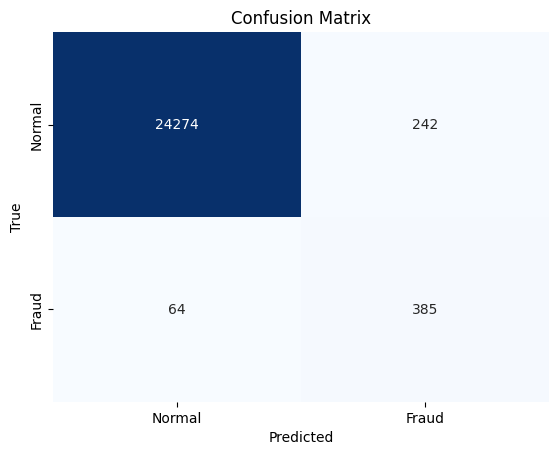

In [57]:
from sklearn.metrics import confusion_matrix

# Confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Normal', 'Fraud'], yticklabels=['Normal', 'Fraud'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [58]:
TN, FP = cm[0, 0], cm[0, 1]  # First row: TN and FP
FN, TP = cm[1, 0], cm[1, 1]  # Second row: FN and TP

TN, FP, FN, TP

(24274, 242, 64, 385)

In [59]:
accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1_score:.2f}")

Accuracy: 0.99
Precision: 0.61
Recall: 0.86
F1 Score: 0.72
